ax + b mod n, base k representation: 3x + 2 mod 5, base 5
Displaying 5 samples from the dataset:
Sample 1: Input: [1, 4, 3, 0, 4, 4, 1, 0, 3, 0, 4, 4, 2, 1, 0, 1]  |  Label: 0
Sample 2: Input: [1, 3, 1, 3, 1, 0, 4, 2, 3, 3, 0, 4, 2, 2, 1, 0]  |  Label: 2
Sample 3: Input: [4, 1, 0, 4, 4, 1, 0, 4, 2, 1, 2, 2, 4, 4, 0, 4]  |  Label: 4
Sample 4: Input: [4, 4, 4, 1, 3, 1, 2, 1, 1, 4, 2, 4, 3, 3, 2, 2]  |  Label: 3
Sample 5: Input: [2, 1, 2, 0, 3, 1, 2, 4, 2, 0, 3, 2, 4, 3, 2, 0]  |  Label: 2
Training Simple MLP for f(x)= a*x+b mod n...
Epoch 1/5 -- Loss: 0.8634 -- Accuracy: 91.36%
Epoch 2/5 -- Loss: 0.2114 -- Accuracy: 96.22%
Epoch 3/5 -- Loss: 0.1052 -- Accuracy: 98.54%
Epoch 4/5 -- Loss: 0.0573 -- Accuracy: 99.21%
Epoch 5/5 -- Loss: 0.0366 -- Accuracy: 99.54%


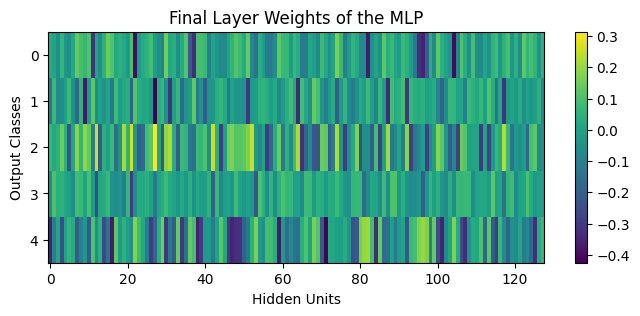

MLP predicted f(42) = 3 (with f(x)= 3*x+2 mod 5)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------
# 1. Data Generation with m-ary Representation
# ----------------------------------------------
def int_to_m_ary(x, base, seq_length):
    """
    Convert an integer x into a list of digits in the specified base,
    zero-padded on the left to length seq_length.
    """
    if x == 0:
        digits = [0]
    else:
        digits = []
        while x:
            digits.append(x % base)
            x //= base
        digits = digits[::-1]
    # Pad with zeros on the left if necessary.
    if len(digits) < seq_length:
        digits = [0] * (seq_length - len(digits)) + digits
    return digits

def generate_modular_integer(a, b, n, base=2, max_value=None, seq_length=16):
    """
    Generate a random integer x (in the range 1 to max_value), convert it to an m-ary representation,
    and compute the label as f(x) = a*x + b (mod n).
    """
    if max_value is None:
        max_value = base ** seq_length - 1
    x = random.randint(1, max_value)
    digits = int_to_m_ary(x, base, seq_length)
    label = (a * x + b) % n
    return digits, label

class ModularArithmeticDataset(Dataset):
    def __init__(self, num_samples=10000, seq_length=16, max_value=None, a=3, b=2, n=5, base=2):
        self.samples = []
        for _ in range(num_samples):
            digits, label = generate_modular_integer(a, b, n, base, max_value, seq_length)
            digits_tensor = torch.tensor(digits, dtype=torch.long)
            label_tensor = torch.tensor(label, dtype=torch.long)
            self.samples.append((digits_tensor, label_tensor))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

def peek_training_data(dataset, num_samples=5):
    print(f"Displaying {num_samples} samples from the dataset:")
    for idx in range(num_samples):
        input_digits, label = dataset[idx]
        digits = input_digits.tolist()
        print(f"Sample {idx+1}: Input: {digits}  |  Label: {label.item()}")

# ----------------------------------------------
# 2. Simple MLP for Learning f(x) = a*x+b mod n
# ----------------------------------------------
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

def train_mlp(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for inputs, labels in dataloader:
        inputs = inputs.float().to(device)  # Convert m-ary digits to float vector
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_mlp(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.float().to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def predict_mlp(x, model, seq_length=16, device=torch.device("cpu"), base=2):
    """
    Given an integer x, convert it to an m-ary representation and predict f(x)=a*x+b mod n.
    """
    digits = int_to_m_ary(x, base, seq_length)
    input_tensor = torch.tensor(digits, dtype=torch.float).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()
    return pred

def visualize_fc_weights_mlp(model):
    """
    Visualize the final layer weights of the MLP.
    """
    # Assuming the last layer is the 5th element in the sequential container.
    fc_weights = model.net[4].weight.detach().cpu().numpy()  # shape: (output_dim, hidden_dim*2)
    plt.figure(figsize=(8, 3))
    plt.imshow(fc_weights, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xlabel("Hidden Units")
    plt.ylabel("Output Classes")
    plt.title("Final Layer Weights of the MLP")
    plt.show()

# ----------------------------------------------
# 3. Setup, Training, Visualization, and Prediction
# ----------------------------------------------
if __name__ == '__main__':
    # Parameters for m-ary representation and modular arithmetic function f(x)= a*x+b mod n
    base = 5               # Change this to desired m (e.g., 3 for ternary)
    seq_length = 16         # Length of the m-ary string
    num_samples = 10000
    batch_size = 64
    num_epochs = 5
    learning_rate = 0.001

    # Modular arithmetic parameters
    a = 3
    b = 2
    n = 5  # number of classes (residues)

    print("ax + b mod n, base k representation: " + str(a) + "x + " + str(b) + " mod " + str(n) + ", base " + str(base))
    # Set max_value so that numbers fit in seq_length digits in the chosen base.
    max_value = base ** seq_length - 1

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create the dataset and dataloader
    dataset_mod = ModularArithmeticDataset(num_samples=num_samples, seq_length=seq_length, max_value=max_value,
                                             a=a, b=b, n=n, base=base)
    dataloader_mod = DataLoader(dataset_mod, batch_size=batch_size, shuffle=True)

    # Peek at the training data
    peek_training_data(dataset_mod, num_samples=5)

    # Define the Simple MLP; flatten the m-ary string as a vector of length seq_length.
    input_dim = seq_length
    hidden_dim = 64
    output_dim = n
    mlp_model = SimpleMLP(input_dim, hidden_dim, output_dim).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)

    # Training loop for the MLP
    print("Training Simple MLP for f(x)= a*x+b mod n...")
    for epoch in range(num_epochs):
        mlp_loss = train_mlp(mlp_model, dataloader_mod, optimizer, criterion, device)
        mlp_accuracy = evaluate_mlp(mlp_model, dataloader_mod, device)
        print(f"Epoch {epoch+1}/{num_epochs} -- Loss: {mlp_loss:.4f} -- Accuracy: {mlp_accuracy*100:.2f}%")

    # Visualize the final layer weights
    visualize_fc_weights_mlp(mlp_model)

    # Inference demonstration
    input_number = 42  # Change to any positive integer
    predicted_value = predict_mlp(input_number, mlp_model, seq_length=seq_length, device=device, base=base)
    print(f"MLP predicted f({input_number}) = {predicted_value} (with f(x)= {a}*x+{b} mod {n})")
